<a href="https://colab.research.google.com/github/Wyw021214/ISP_autism/blob/main/projects/fMRI/CNN_HCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q nilearn nibabel pandas numpy matplotlib requests boto3 awscli seaborn
!pip install -q nibabel nilearn numpy scikit-learn matplotlib pandas scipy
!pip install -q hcp_utils brainspace actflow


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Necessary for visualization
from nilearn import plotting, datasets

import h5py
import pkg_resources
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

import ActflowToolbox as actflow

import torch
from torch.utils.data import Dataset, DataLoader

<ipython-input-2-36cb4277bc5a>:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Generated by GPT, not yet verified

aal_network_labels = [
    "Visual", "Visual", "Visual", "Visual", "Somatomotor", "Somatomotor", "Somatomotor", "Somatomotor",
    "DorsalAttention", "DorsalAttention", "DorsalAttention", "DorsalAttention",
    "VentralAttention", "VentralAttention", "VentralAttention", "VentralAttention",
    "Limbic", "Limbic", "Limbic", "Limbic",
    "Frontoparietal", "Frontoparietal", "Frontoparietal", "Frontoparietal",
    "DefaultMode", "DefaultMode", "DefaultMode", "DefaultMode",
    "Subcortical", "Subcortical", "Subcortical", "Subcortical",
]

#Convert to numerical labels
network_dict = {net: idx for idx, net in enumerate(sorted(set(aal_network_labels)))}
network_labels_numeric = [network_dict[net] for net in aal_network_labels]

# Compute network order
netorder = np.argsort(network_labels_numeric)  # Sort ROIs by network

# Step 5️⃣: Print network order for verification
print(f"Network order indices: {netorder}")

Network order indices: [27 24 25 26 11  8  9 10 21 20 22 23 16 17 18 19  6  5  4  7 30 28 29 31
 15 13 12 14  3  2  1  0]


In [6]:
# Paths
output_base_dir = "/content/drive/MyDrive/HCP_1200_processed"

# List of subjects to process
subject_list_path = "/content/drive/MyDrive/hcp1200_subjects.txt"
with open(subject_list_path, "r") as file:
    subject_ids = [line.strip() for line in file.readlines()]

subject_ids = subject_ids  # Use the first 30 subjects
N_SUBJECTS = len(subject_ids)

task_conditions = ["WM_LR_0bk_body", "WM_LR_2bk_body", "WM_LR_0bk_faces", "WM_LR_2bk_faces",
  "WM_LR_0bk_places", "WM_LR_2bk_places", "WM_LR_0bk_tools", "WM_LR_2bk_tools",
 "WM_RL_0bk_body", "WM_RL_2bk_body", "WM_RL_0bk_faces", "WM_RL_2bk_faces",
  "WM_RL_0bk_places", "WM_RL_2bk_places", "WM_RL_0bk_tools", "WM_RL_2bk_tools",
 "SOCIAL_LR_mental", "SOCIAL_LR_rnd", "SOCIAL_RL_mental", "SOCIAL_RL_rnd",
 ]

# Task and resting-state data
N_PARCELS = 84  # Number of AAL parcels
N_TASKS = 20     # Number of tasks
TIME_CHUNK = 1200  # Average over 1200 time points

# Initialize lists to store valid subject data
valid_subjects = []
restdata_list = []
activations_list = []
problematic_subjects = []  # Store subjects with incorrect task shape

# Load data for each subject
for subj_idx, subject_id in enumerate(subject_ids):
    subject_output_dir = os.path.join(output_base_dir, subject_id)

    # Load resting-state data
    rest_file = os.path.join(subject_output_dir, "rest.npy")
    if os.path.exists(rest_file):
        subject_restdata = np.load(rest_file)  # Shape: (84, timepoints)

        # Average over chunks of 1200 time points
        num_chunks = subject_restdata.shape[1] // TIME_CHUNK
        subject_restdata_avg = np.mean(
            subject_restdata[:, :num_chunks * TIME_CHUNK].reshape(N_PARCELS, num_chunks, TIME_CHUNK),
            axis=1
        )  # Shape: (84, 1200)

    else:
        print(f"WARNING: Missing resting-state data for Subject {subject_id}")
        continue  # Skip this subject

    # Load task activations
    task_file = os.path.join(subject_output_dir, "task.npy")
    if os.path.exists(task_file):
        subject_taskdata = np.load(task_file)  # Expected Shape: (84, 4)

        # Check for shape mismatch
        if subject_taskdata.shape[1] != N_TASKS:
            print(f"WARNING: Subject {subject_id} has task data shape {subject_taskdata.shape}, expected (84, {N_TASKS})")
            problematic_subjects.append(subject_id)
            continue  # Skip this subject

    else:
        print(f"WARNING: Missing task data for Subject {subject_id}")
        continue  # Skip this subject

    # Only add valid subjects
    valid_subjects.append(subject_id)
    restdata_list.append(subject_restdata_avg)
    activations_list.append(subject_taskdata)

# Convert lists to numpy arrays
restdata = np.stack(restdata_list, axis=2)  # Shape: (84, 1200, valid_subjects_count)
activations_bycond = np.stack(activations_list, axis=2)  # Shape: (84, 20, valid_subjects_count)

# Verify final shape
print("Final Restdata shape:", restdata.shape)  # Expected: (84, 1200, valid_subjects_count)
print("Final Activations_bycond shape:", activations_bycond.shape)  # Expected: (84, 20, valid_subjects_count)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  -----
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  DeprecationWarning,


Final Restdata shape: (84, 1200, 1096)
Final Activations_bycond shape: (84, 20, 1096)


In [7]:
def safe_corrcoef(X):
    """Compute correlation matrix with small regularization to avoid NaNs."""
    X = X - np.mean(X, axis=1, keepdims=True)  # Zero-center
    X_std = np.std(X, axis=1, keepdims=True)

    # Regularization: Avoid division by zero
    X_std[X_std < 1e-10] = 1e-10  # Small nonzero value to prevent NaNs
    X = X / X_std

    # Use np.nan_to_num to handle potential NaNs during correlation calculation
    corr_matrix = np.corrcoef(X)
    corr_matrix = np.nan_to_num(corr_matrix)
    return corr_matrix

# Replace NaNs with Small Nonzero Value
restdata = np.nan_to_num(restdata, nan=1e-10)  # Replace NaNs

# Compute Pearson Correlation FC (Keeps All ROIs)
restFC_corr = np.zeros((N_PARCELS, N_PARCELS, restdata.shape[2]))

for subj_idx in range(restdata.shape[2]):
    subject_restdata = restdata[:, :, subj_idx]

    if np.isnan(subject_restdata).sum() > 0:
        print(f"Warning: Subject {subj_idx} contains NaNs in `restdata`. Skipping FC calculation.")
        continue

    restFC_corr[:, :, subj_idx] = safe_corrcoef(subject_restdata)

nan_count = np.isnan(restFC_corr).sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values detected in `restFC_corr` after computation.")

print("Functional Connectivity Matrix Computed Successfully")


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  Most references to the Blackman window come from the signal processing


Functional Connectivity Matrix Computed Successfully


In [11]:
def compute_brainsurfcnn_task_contrast(activations_bycond, task_conditions):
    """
    Compute task contrasts following BrainSurfCNN’s exact methodology.

    activations_bycond: (ROI, num_tasks, subjects) -> Task activations for each condition
    task_conditions: List of task condition names

    Returns:
    task_contrast: (ROI, num_contrasts, subjects)
    """

    # Define condition pairs for contrasts (BrainSurfCNN structure)
    contrast_pairs = {
        "SOCIAL_LR": ["SOCIAL_LR_mental", "SOCIAL_LR_rnd"],
        "SOCIAL_RL": ["SOCIAL_RL_mental", "SOCIAL_RL_rnd"],
        "WM_LR_BODY": ["WM_LR_2bk_body", "WM_LR_0bk_faces"],
        "WM_LR_FACES": ["WM_LR_2bk_faces", "WM_LR_0bk_places"],
        "WM_LR_PLACE": ["WM_LR_2bk_places", "WM_LR_0bk_tools"],
        "WM_LR_TOOL": ["WM_LR_2bk_tools", "WM_LR_0bk_body"],
        "WM_RL_BODY": ["WM_RL_2bk_body", "WM_RL_0bk_faces"],
        "WM_RL_FACES": ["WM_RL_2bk_faces", "WM_RL_0bk_places"],
        "WM_RL_PLACE": ["WM_RL_2bk_places", "WM_RL_0bk_tools"],
        "WM_RL_TOOL": ["WM_RL_2bk_tools", "WM_RL_0bk_body"]
    }

    num_subjects = activations_bycond.shape[2]
    num_rois = activations_bycond.shape[0]
    task_contrast = np.zeros((num_rois, len(contrast_pairs), num_subjects))

    for i, (task, conditions) in enumerate(contrast_pairs.items()):
        try:
            # Get indices for paired conditions
            task_idx = task_conditions.index(conditions[0])  # Task condition
            baseline_idx = task_conditions.index(conditions[1])  # Control/Baseline condition

            # Compute contrast as (Task - Baseline)
            task_contrast[:, i, :] = (
                activations_bycond[:, task_idx, :] - activations_bycond[:, baseline_idx, :]
            )
        except ValueError:
            print(f"Skipping {task}: One or both conditions missing in task_conditions")

    return task_contrast

# Compute task contrast using BrainSurfCNN methodology
task_contrast = compute_brainsurfcnn_task_contrast(activations_bycond, task_conditions)

# Verify shape
print("BrainSurfCNN Task Contrast shape:", task_contrast.shape)  # Expected: (ROI, num_task_contrasts, subjects)


BrainSurfCNN Task Contrast shape: (84, 10, 1096)


In [13]:
output_dir = "/content/drive/MyDrive/cnn_processed_data"
os.makedirs(output_dir, exist_ok=True)

# Save adjusted task contrast
np.save(os.path.join(output_dir, "task_contrast_brainsurfcnn.npy"), task_contrast)
np.save(os.path.join(output_dir, "restFC_corr.npy"), restFC_corr)
print("Task Contrast and restFC saved successfully!")

Task Contrast and restFC saved successfully!


In [12]:
output_dir = "/content/drive/MyDrive/cnn_processed_data"
task_contrast_path = os.path.join(output_dir, "task_contrast_brainsurfcnn.npy")
restFC_corr_path = os.path.join(output_dir, "restFC_corr.npy")
contrast_pairs = {
        "SOCIAL_LR": ["SOCIAL_LR_mental", "SOCIAL_LR_rnd"],
        "SOCIAL_RL": ["SOCIAL_RL_mental", "SOCIAL_RL_rnd"],
        "WM_LR_BODY": ["WM_LR_2bk_body", "WM_LR_0bk_faces"],
        "WM_LR_FACES": ["WM_LR_2bk_faces", "WM_LR_0bk_places"],
        "WM_LR_PLACE": ["WM_LR_2bk_places", "WM_LR_0bk_tools"],
        "WM_LR_TOOL": ["WM_LR_2bk_tools", "WM_LR_0bk_body"],
        "WM_RL_BODY": ["WM_RL_2bk_body", "WM_RL_0bk_faces"],
        "WM_RL_FACES": ["WM_RL_2bk_faces", "WM_RL_0bk_places"],
        "WM_RL_PLACE": ["WM_RL_2bk_places", "WM_RL_0bk_tools"],
        "WM_RL_TOOL": ["WM_RL_2bk_tools", "WM_RL_0bk_body"]
    }


# Load data
task_contrast = np.load(task_contrast_path)
restFC_corr = np.load(restFC_corr_path)

# Display shape information
print("Loaded Task Contrast Shape:", task_contrast.shape)  # Expected: (ROI, num_task_contrasts, subjects)
print("Loaded Functional Connectivity Shape:", restFC_corr.shape)  # Expected: (ROI, ROI, subjects)

# Transpose data for PyTorch compatibility
task_contrast = task_contrast.transpose(2, 0, 1)  # (subjects, 84, num_task_contrasts)
restFC_corr = restFC_corr.transpose(2, 0, 1)  # Transpose to (subjects, ROI, ROI)
restFC_corr = restFC_corr[:, np.newaxis, ...] # Add a new dimension for channels


Loaded Task Contrast Shape: (84, 10, 1096)
Loaded Functional Connectivity Shape: (84, 84, 1096)


In [14]:
from sklearn.model_selection import train_test_split
import torch

# Define split ratio
train_ratio = 0.9  # 90% training, 10% testing

# Get number of subjects
num_subjects = restFC_corr.shape[0]

# Split indices into train and test sets
train_indices, test_indices = train_test_split(np.arange(num_subjects), test_size=1-train_ratio, random_state=42)

# Create train and test datasets
train_fc = restFC_corr[train_indices]
train_task_contrast = task_contrast[train_indices]

test_fc = restFC_corr[test_indices]
test_task_contrast = task_contrast[test_indices]

print(f"Training subjects: {len(train_indices)}, Testing subjects: {len(test_indices)}")


Training subjects: 986, Testing subjects: 110


In [15]:
class BrainSurfCNN_Dataset(Dataset):
    def __init__(self, fc_data, task_contrast):
        """
        Args:
            fc_data (numpy array): Functional connectivity matrices (subjects, 1, 84, 84)
            task_contrast (numpy array): Task contrasts (subjects, 84, num_task_contrasts)
        """
        self.fc_data = torch.tensor(fc_data, dtype=torch.float32)
        self.task_contrast = torch.tensor(task_contrast, dtype=torch.float32)

    def __len__(self):
        return self.fc_data.shape[0]  # Number of subjects

    def __getitem__(self, idx):
        return self.fc_data[idx], self.task_contrast[idx]

# Create dataset
train_dataset = BrainSurfCNN_Dataset(train_fc, train_task_contrast)
test_dataset = BrainSurfCNN_Dataset(test_fc, test_task_contrast)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print("Train & Test sets prepared!")

Train & Test sets prepared!


## Define BrainSurfCNN Model

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class BrainSurfCNN(nn.Module):
    def __init__(self, roi_size=84, num_contrasts=10):
        super(BrainSurfCNN, self).__init__()

        # Encoding layers (Feature Extraction)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * roi_size * roi_size, 1024)
        self.fc2 = nn.Linear(1024, roi_size * num_contrasts)  # Output (ROI × Task Contrasts)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.dropout(x)
        x = x.view(x.shape[0], -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.view(x.shape[0], 84, 10)  # (Batch, ROI, num_task_contrasts)

# Initialize model and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainSurfCNN().to(device)

print("BrainSurfCNN model initialized and moved to GPU!")


BrainSurfCNN model initialized and moved to GPU!


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BrainSurfCNN(nn.Module):
    def __init__(self, roi_size=84, num_contrasts=10):
        super(BrainSurfCNN, self).__init__()

        ## ============================
        ## Downstream Path (Encoder)
        ## ============================
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        ## ============================
        ## Bottleneck Layer
        ## ============================
        self.conv_bottleneck = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn_bottleneck = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)

        ## ============================
        ## Upstream Path (Decoder)
        ## ============================
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(64)

        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(32)

        ## ============================
        ## Fully Connected Layers (Match 84 x 10 Output)
        ## ============================
        self.fc1 = nn.Linear(32 * roi_size * roi_size, 2048)  # Expanded FC for better learning
        self.fc2 = nn.Linear(2048, roi_size * num_contrasts)  # Output: (ROI, Task Contrasts)

    def forward(self, x):
        ## Downstream Path (Encoder)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        x3 = F.relu(self.bn3(self.conv3(x2)))
        x4 = F.relu(self.bn4(self.conv4(x3)))

        ## Bottleneck Layer
        x_bottleneck = F.relu(self.bn_bottleneck(self.conv_bottleneck(x4)))
        x_bottleneck = self.dropout(x_bottleneck)

        ## Upstream Path (Decoder)
        x = F.relu(self.bn5(self.deconv1(x_bottleneck)) + x4)  # Skip connection
        x = F.relu(self.bn6(self.deconv2(x)) + x3)  # Skip connection
        x = F.relu(self.bn7(self.deconv3(x)) + x2)  # Skip connection
        x = F.relu(self.bn8(self.deconv4(x)) + x1)  # Skip connection

        ## Fully Connected Output
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.view(x.shape[0], 84, 10)  # Output shape: (Batch, ROI, Task Contrasts)

# Initialize model and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainSurfCNN().to(device)
print("BrainSurfCNN Model Initialized and moved to GPU!")


BrainSurfCNN Model Initialized and moved to GPU!


In [27]:
device

device(type='cuda')

In [28]:
import torch.optim as optim

# Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Regression loss

# Use Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for fc_matrix, task_contrast in train_loader:
        fc_matrix, task_contrast = fc_matrix.to(device), task_contrast.to(device)

        optimizer.zero_grad()

        outputs = model(fc_matrix)
        loss = criterion(outputs, task_contrast)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

print("BrainSurfCNN training completed!")


<ipython-input-28-de09ccfbe3e7>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch [1/10], Loss: 5.5291
Epoch [2/10], Loss: 0.0603
Epoch [3/10], Loss: 0.0367
Epoch [4/10], Loss: 0.0360
Epoch [5/10], Loss: 0.0356
Epoch [6/10], Loss: 0.0355
Epoch [7/10], Loss: 0.0355
Epoch [8/10], Loss: 0.0355
Epoch [9/10], Loss: 0.0355
Epoch [10/10], Loss: 0.0355
BrainSurfCNN training completed with mixed precision!


In [29]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Initialize dictionary to store correlations for each subject-task pair
subject_task_correlations = {}

model.eval()
with torch.no_grad():
    for subject_idx, (fc_matrix, task_contrast) in enumerate(test_loader):
        fc_matrix, task_contrast = fc_matrix.to(device), task_contrast.to(device)

        outputs = model(fc_matrix)  # Predicted values

        # Convert to numpy
        true_values = task_contrast.cpu().numpy()  # Shape: (batch_size, ROI, num_tasks)
        predicted_values = outputs.cpu().numpy()  # Same shape

        for batch_idx in range(true_values.shape[0]):  # Iterate over batch size
            subject_id = test_indices[subject_idx * test_loader.batch_size + batch_idx]  # Get original subject index

            task_correlations = []
            for task in range(true_values.shape[2]):  # Iterate over tasks
                true_vals = true_values[batch_idx, :, task]  # Shape: (ROI,)
                pred_vals = predicted_values[batch_idx, :, task]  # Shape: (ROI,)

                # Compute Pearson correlation if values are not constant
                if np.std(true_vals) > 0 and np.std(pred_vals) > 0:
                    r, _ = stats.pearsonr(true_vals, pred_vals)
                    task_correlations.append(r)
                else:
                    task_correlations.append(np.nan)  # Store NaN for constant values

            subject_task_correlations[subject_id] = task_correlations

# Convert to numpy array for further analysis
subject_task_correlations_array = np.array(list(subject_task_correlations.values()))

# Compute mean correlation per subject and across all subjects
mean_correlation_per_subject = np.nanmean(subject_task_correlations_array, axis=1)
overall_mean_correlation = np.nanmean(subject_task_correlations_array)

print(f"Overall Mean Correlation Across All Subjects and Tasks: {overall_mean_correlation:.4f}")

Overall Mean Correlation Across All Subjects and Tasks: 0.4400


<ipython-input-29-47e4edd3b977>:39: RuntimeWarning: Mean of empty slice
  mean_correlation_per_subject = np.nanmean(subject_task_correlations_array, axis=1)


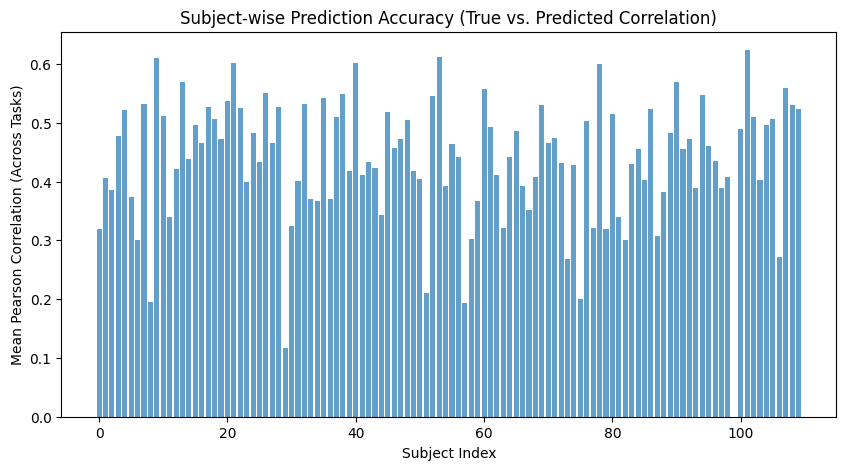

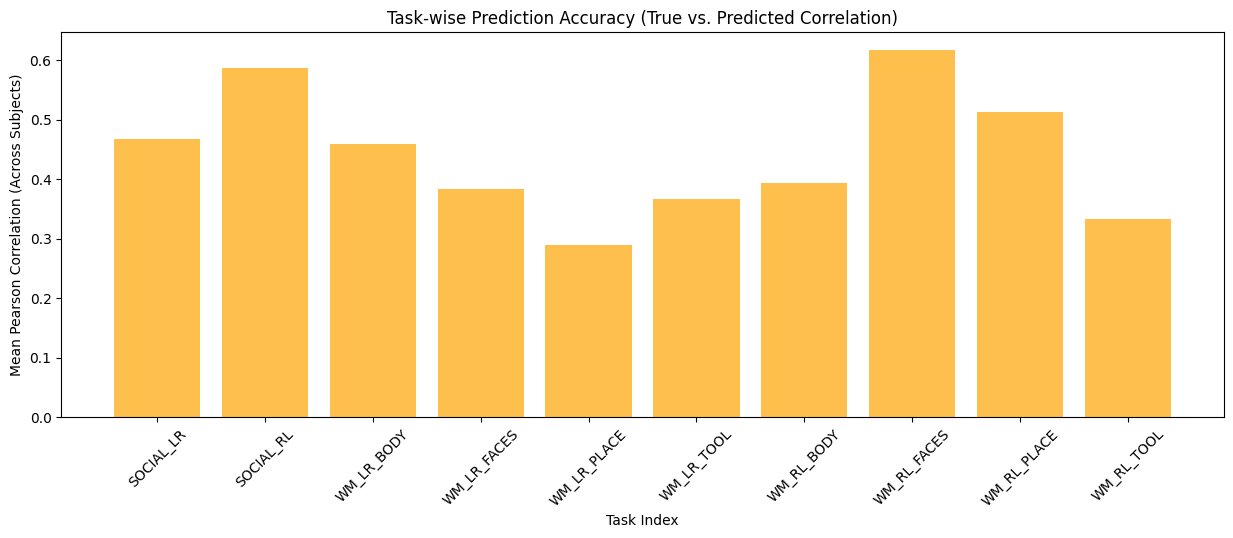

In [31]:
# Plot subject-wise correlation
plt.figure(figsize=(10, 5))
plt.bar(range(len(mean_correlation_per_subject)), mean_correlation_per_subject, alpha=0.7)
plt.xlabel("Subject Index")
plt.ylabel("Mean Pearson Correlation (Across Tasks)")
plt.title("Subject-wise Prediction Accuracy (True vs. Predicted Correlation)")
plt.show()

# Plot task-wise correlation (Mean correlation per task across all subjects)
mean_correlation_per_task = np.nanmean(subject_task_correlations_array, axis=0)

plt.figure(figsize=(15, 5))
plt.bar(contrast_pairs.keys() , mean_correlation_per_task, alpha=0.7, color='orange')
plt.xlabel("Task Index")
plt.ylabel("Mean Pearson Correlation (Across Subjects)")
plt.title("Task-wise Prediction Accuracy (True vs. Predicted Correlation)")
plt.xticks(rotation=45)
plt.show()
